In [35]:
# All data
with open(datapath+'all_data.pkl', 'rb') as handle:
    all_data = pkl.load(handle)
    
print(all_data.dtypes)

with open(datapath+'all_locs.pkl', 'rb') as handle:
    locations = pkl.load(handle)
    
locations = locations.set_index('id')

print(locations.dtypes)



Start Date         datetime64[ns]
StartStation Id           float64
End Date           datetime64[ns]
EndStation Id             float64
Duration                  float64
dtype: object


In [133]:
def get_colors(ar):
    col1 = (32/255, 166/255, 255/255)
    col2 = (78/255, 85/255, 140/255)
    
    colors = []
    for i in range(len(ar)):
        lerp = i/(len(ar) - 1)
        colors += [[col1[j] * lerp + col2[j] * (1-lerp) for j in range(3)]]
    
    return colors

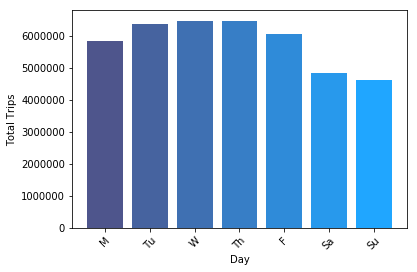

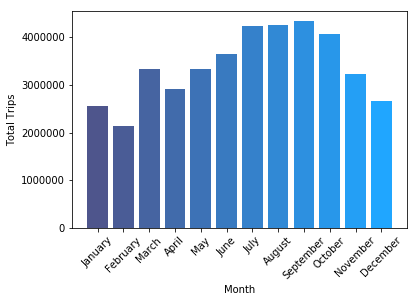

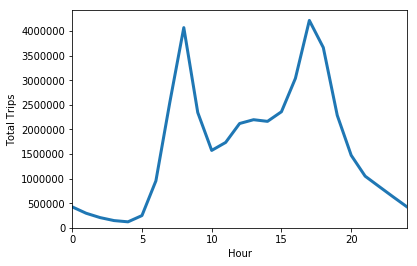

In [134]:

# Get average traffic by day
traffic = []
days = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']
for i, day in enumerate(days):
    traffic.append(len(all_data[all_data['Start Date'].dt.dayofweek == i]))

cols = get_colors(days)
plt.bar(days, traffic, color=cols)
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Total Trips')

plt.gcf().savefig('trips by day.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Get average traffic by month
traffic = []
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i, month in enumerate(months):
    traffic.append(len(all_data[all_data['Start Date'].dt.month == i+1]))
    
plt.bar(months, traffic, color=get_colors(months))
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Trips')

plt.gcf().savefig('trips by month.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Get average traffic by hour
traffic = []
for hour in range(24):
    traffic += [len(all_data[all_data['Start Date'].dt.hour == hour])]
    
traffic += traffic[:1]

plt.plot(traffic, lw=3)
plt.xlabel('Hour')
plt.ylabel('Total Trips')
plt.xlim(0, 24)
plt.ylim(ymin=0)

plt.gcf().savefig('trips by hour.pdf', format='pdf', bbox_inches='tight')
plt.show()

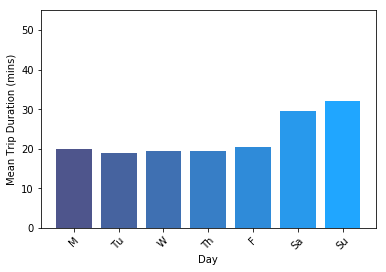

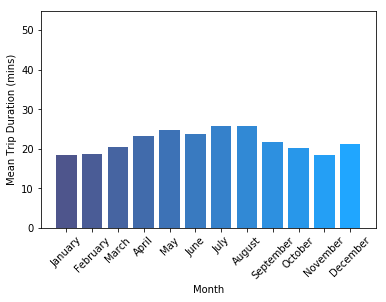

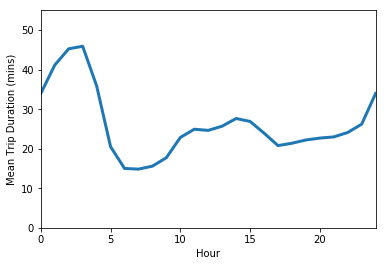

In [135]:
# Avoid large negative durations!
sub = all_data[all_data['Duration'] >= 0]

# Get average duration by day
traffic = []
days = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

for i, day in enumerate(days):
    traffic.append(sub[sub['Start Date'].dt.dayofweek == i]['Duration'].mean()/60)

plt.bar(days, traffic, color=get_colors(days))
plt.xticks(rotation=45)
plt.xlabel('Day')
plt.ylabel('Mean Trip Duration (mins)')
plt.ylim(0, 55)

plt.gcf().savefig('duration by day.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Get average traffic by month
traffic = []
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for i, month in enumerate(months):
    traffic.append(sub[sub['Start Date'].dt.month == i+1]['Duration'].mean()/60)

cols = [(i/len(months)/2 + 0.5, 0.25, 1-i/len(months)/2) for i in range(len(months))]

plt.bar(months, traffic, color=get_colors(months))
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Mean Trip Duration (mins)')
plt.ylim(0, 55)

plt.gcf().savefig('duration by month.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Get average duration by hour
traffic = []
for hour in range(24):
    traffic.append(sub[sub['Start Date'].dt.hour == hour]['Duration'].mean()/60)
    
traffic += traffic[:1]

plt.plot(traffic, lw=3)
plt.xlabel('Hour')
plt.ylabel('Mean Trip Duration (mins)')
plt.xlim(0, 24)
plt.ylim(0, 55)

plt.gcf().savefig('duration by hour.pdf', format='pdf', bbox_inches='tight')
plt.show()

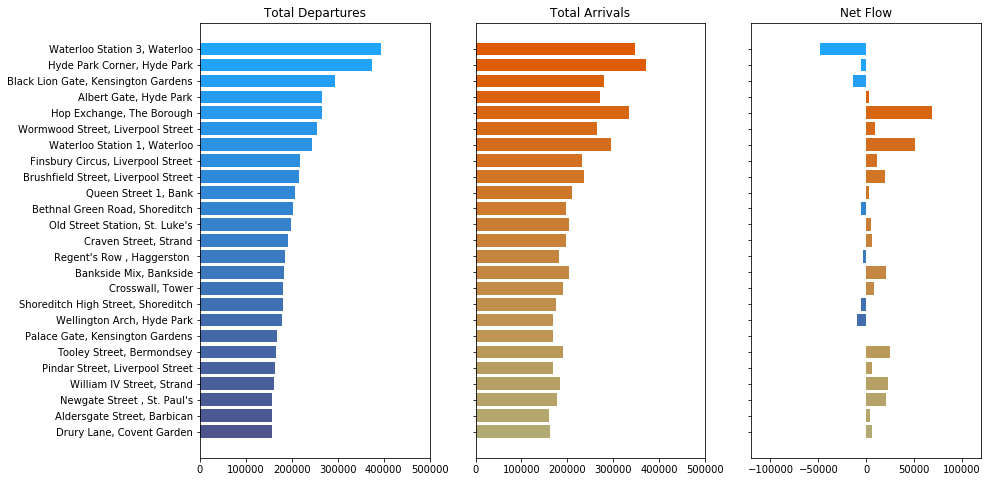

In [175]:
# Average traffic by station
start = all_data.groupby('StartStation Id')['Duration'].count()
end = all_data.groupby('EndStation Id')['Duration'].count()
diff = end - start

start.head()

locations['Departures'] = start
locations['Arrivals'] = end

locations = locations.sort_values(by='Departures', ascending=False)

start = locations['Departures'].iloc[25:0:-1]
end = locations['Arrivals'].iloc[25:0:-1]
diff = end - start
locs = locations['name'].iloc[25:0:-1]

# Get xlocation names
fig, axes = plt.subplots(ncols=3, sharey=True)

cols = get_colors(locs)
axes[0].barh(locs, start, color=cols)
axes[0].set_title('Total Departures')
axes[0].set_xlim(0, 500000)

inv_cols = [[1-c for c in col] for col in cols]
axes[1].barh(locs, end, color=inv_cols)
axes[1].set_title('Total Arrivals')
axes[1].set_xlim(0, 500000)

colors = []
for i, d in enumerate(diff):
    if d < 0:
        colors += [cols[i]]
    else:
        colors += [inv_cols[i]]

axes[2].barh(locs, diff, color=colors)
axes[2].set_title('Net Flow')
axes[2].set_xlim(-120000, 120000)

#plt.legend(frameon=False)
fig.set_size_inches(14, 8)
fig.savefig('traffic.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [141]:
# Get traffic for every 10 minutes
start = []
end = []
for time in range(24*6):
    hour = time // 6
    mins = (time % 6 ) * 10
    
    sub = all_data[all_data['Start Date'].dt.hour == hour]
    sub = sub[sub['Start Date'].dt.minute < mins + 10]
    sub = sub[sub['Start Date'].dt.minute >= mins]
    
    start += [sub.groupby('StartStation Id')['Duration'].count().reindex(locations.index)]
    
    sub = all_data[all_data['End Date'].dt.hour == hour]
    sub = sub[sub['End Date'].dt.minute < mins + 10]
    sub = sub[sub['End Date'].dt.minute >= mins]
    end += [sub.groupby('EndStation Id')['Duration'].count().reindex(locations.index)]
    

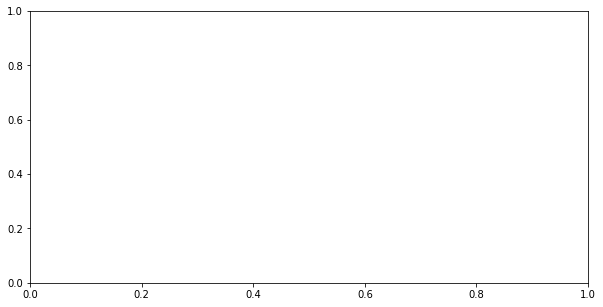

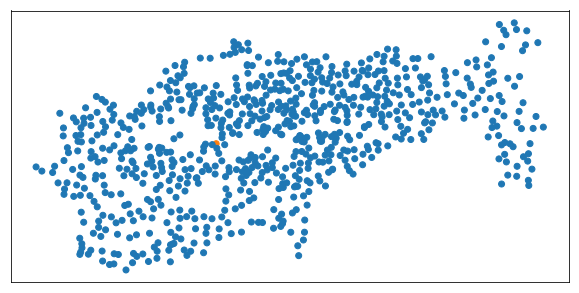

In [196]:
import numpy as np

m = Basemap(resolution=None, # c, l, i, h, f or None
            projection='merc',
            lat_0=51.5, lon_0=-0.125,
            llcrnrlon=-0.25, llcrnrlat= 51.45, urcrnrlon=0, urcrnrlat=51.6)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

x, y = m(list(locations['lon']), list(locations['lat']))

colors = []
import numpy as np

m = Basemap(resolution=None, # c, l, i, h, f or None
            projection='merc',
            lat_0=51.5, lon_0=-0.125,
            llcrnrlon=-0.25, llcrnrlat= 51.45, urcrnrlon=0, urcrnrlat=51.6)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

x, y = m(list(locations['lon']), list(locations['lat']))

colors = []
for i in locations.index:
    if locations['name'].loc[i] == 'Hyde Park Corner, Hyde Park':
        colors += ['C1']
    else:
        colors += ['C0']

ax.scatter(x, y, c=colors)

# plt.xlim(-0.25, 0)
# plt.ylim(51.45, 51.575)
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(10, 5)
fig.savefig('highlighted map.pdf', format='pdf', bbox_inches='tight')


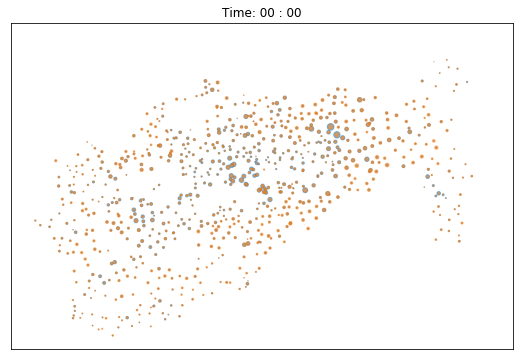

In [170]:
# Plot at 10 minute intervals
from matplotlib import animation, rc
from IPython.display import HTML

from mpl_toolkits.basemap import Basemap

m = Basemap(resolution=None, # c, l, i, h, f or None
            projection='merc',
            lat_0=51.5, lon_0=-0.125,
            llcrnrlon=-0.25, llcrnrlat= 51.45, urcrnrlon=0, urcrnrlat=51.6)

fig, ax = plt.subplots()
fig.set_size_inches(9, 6)

x, y = m(list(locations['lon']), list(locations['lat']))

def animate(frame):
    
    fph = 6
    hour = frame // fph
    mins = (frame - hour * fph)*10
    
    ax.clear()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 30000)
    ax.set_ylim(0, 20000)

    ax.set_title('Time: {:02d} : {:02d}'.format(hour, mins))

    s = start[frame]
    e = end[frame]

    scatter = ax.scatter(x, y,
                         s = s / 25, color='C0', alpha=0.5)
    
    scatter2 = ax.scatter(x, y,
                          s = e / 25, color='C1', alpha=0.5)
    
    return scatter,scatter2,
    
  
anim = animation.FuncAnimation(fig, animate, frames=24 * 6, interval=20, repeat=True)
HTML(anim.to_jshtml())
anim.save('traffic.gif', writer='pillow')

In [105]:
# Get change in bikes and totals
total = [start[0] * 0]

for i in range(len(start)):
    total += [total[-1] + end[i] - start[i]]
    
min_bikes = start[0] * 0

for i in min_bikes.index:
    min_total = 0
    for j in range(len(total)):
        min_total = min(min_total, total[j].loc[i])
        
    min_bikes.loc[i] = min_total
        
print(min_bikes.min())
print(min_bikes.max())
print(min_bikes.mean())

min_total = 0
for tot in total:
    min_total = min(min_total, tot.min())
    
print(min_total)

-279803.0
0.0
-7366.012804097311
-279803.0


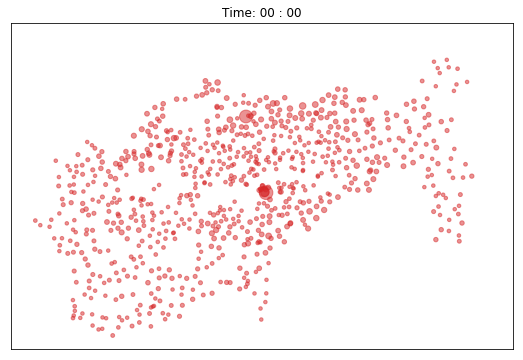

In [169]:
# Plot at 10 minute intervals - total number of bikes!
from matplotlib import animation, rc
from IPython.display import HTML

m = Basemap(resolution=None, # c, l, i, h, f or None
            projection='merc',
            lat_0=51.5, lon_0=-0.125,
            llcrnrlon=-0.25, llcrnrlat= 51.45, urcrnrlon=0, urcrnrlat=51.6)

x, y = m(list(locations['lon']), list(locations['lat']))

fig, ax = plt.subplots()
fig.set_size_inches(9, 6)

def animate(frame):
    
    fph = 6
    hour = frame // fph
    mins = (frame - hour * fph)*10
    
    ax.clear()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 30000)
    ax.set_ylim(0, 20000)

    ax.set_title('Time: {:02d} : {:02d}'.format(hour, mins))

    total = -1 * min_bikes + 20000
    for i in range(frame):
        total += end[frame] - start[frame]
        
    total = total.clip(lower=1)

    scatter = ax.scatter(x, y,
                         s = total / 1600, color='C3', alpha=0.5)
    
    return scatter,
    
  
anim = animation.FuncAnimation(fig, animate, frames=24 * 6, interval=20)
HTML(anim.to_jshtml())
anim.save('total.gif', writer='pillow')

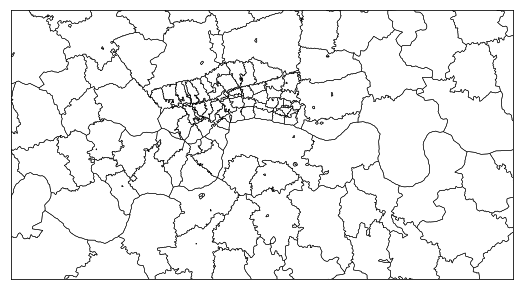

In [185]:
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots()
fig.set_size_inches(9, 6)

m = Basemap(resolution=None, # c, l, i, h, f or None
            projection='merc',
            llcrnrlon=-0.25, llcrnrlat= 51.45, urcrnrlon=0.05, urcrnrlat=51.55)

areas = m.readshapefile(datapath+'Maps/Districts', 'areas')

plt.gcf().savefig('london map.pdf', format='pdf', bbox_inches='tight')
plt.show()

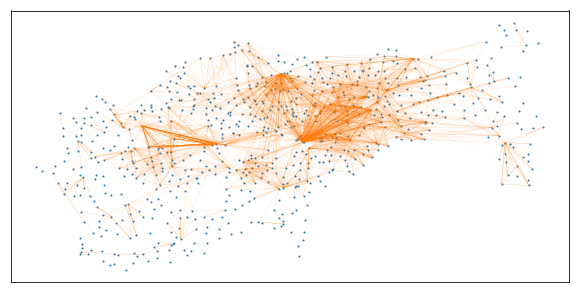

In [172]:
import numpy as np

m = Basemap(resolution=None, # c, l, i, h, f or None
            projection='merc',
            lat_0=51.5, lon_0=-0.125,
            llcrnrlon=-0.25, llcrnrlat= 51.45, urcrnrlon=0, urcrnrlat=51.6)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# Network of completed journeys
counts = all_data.groupby(by=['StartStation Id', 'EndStation Id'])['Duration'].count()

x, y = m(list(locations['lon']), list(locations['lat']))

ax.scatter(x, y, s=1)

for i in locations.index:
    sub = counts[i]
    for j in locations.index:
        if type(sub) == np.int64:
            continue
            
        if j in sub.index:
            
            if sub[j] < 1000:
                continue
            
            x, y = m([locations['lon'].loc[i], locations['lon'].loc[j]],
                     [locations['lat'].loc[i], locations['lat'].loc[j]])
            ax.plot(x, y,
                     lw=3 * sub[j]/counts.max(), color='C1', alpha=1)

# plt.xlim(-0.25, 0)
# plt.ylim(51.45, 51.575)
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(10, 5)
fig.savefig('trip network.pdf', format='pdf', bbox_inches='tight')
fig.savefig('trip network.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

In [198]:

print(counts.sort_values(ascending=False))

StartStation Id  EndStation Id
191.0            191.0            97089
307.0            307.0            57515
303.0            303.0            51817
406.0            406.0            32606
407.0            407.0            31886
248.0            248.0            29620
404.0            404.0            27213
307.0            404.0            22007
191.0            303.0            21783
213.0            213.0            20033
307.0            191.0            19887
404.0            307.0            19166
191.0            307.0            17998
303.0            191.0            17960
304.0            304.0            16191
350.0            350.0            15782
307.0            303.0            15171
407.0            406.0            15005
191.0            248.0            14607
                 300.0            14009
248.0            191.0            13517
303.0            407.0            13151
                 307.0            13140
785.0            785.0            13042
407.0    

       name  capacity        lat       lon
0   Aldgate       155  51.514046 -0.074628
1     Angel       260  51.533240 -0.106523
2  Avondale       171  51.511550 -0.215143
3      Bank       117  51.512803 -0.091630
4  Bankside       210  51.506176 -0.098243


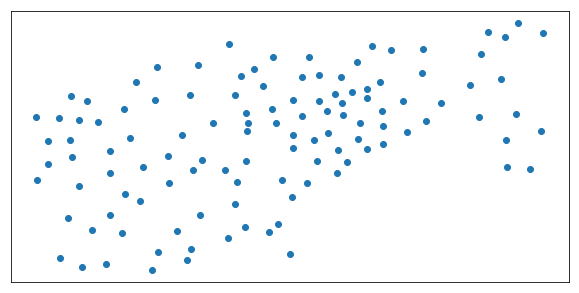

In [243]:
with open(datapath+'clustered_locs.pkl', 'rb') as handle:
    clustered_locs = pkl.load(handle)
    
print(clustered_locs.head())

x, y = m(list(clustered_locs['lon']), list(clustered_locs['lat']))
plt.scatter(x, y)

plt.xticks([])
plt.yticks([])
plt.gcf().set_size_inches(10, 5)
plt.gcf().savefig('cluster map.png', format='png', dpi=200)

In [266]:
# Draw driver locations

with open(datapath+'baseline_sim_result_Wed_01_Apr_15_0600-1200_tfl_strategy_30_bikes.pkl', 'rb') as handle:
    van_data = pkl.load(handle)
    
van_df = pd.DataFrame(van_data,
                     columns=['start', 'end', 'van', 'start loc', 'end loc', 'score'])

van_df.head()

print(van_df.head())

print(van_df['score'].min())

                start                 end  van  start loc  end loc  score
0 2015-04-01 06:00:00 2015-04-01 06:09:00    0         78       10      0
1 2015-04-01 06:00:00 2015-04-01 06:09:00    1         55       37      0
2 2015-04-01 06:00:00 2015-04-01 06:09:00    2         78       10      0
3 2015-04-01 06:00:00 2015-04-01 06:09:00    5         91        3      0
4 2015-04-01 06:00:00 2015-04-01 06:09:00    6        112       88      0
-1740


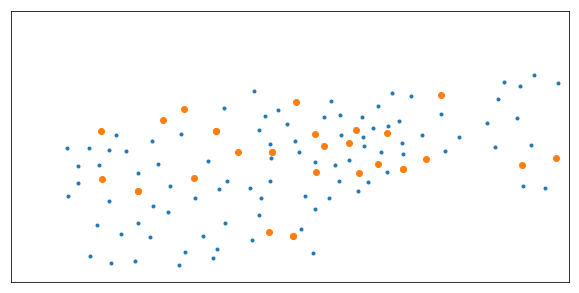

In [265]:
drivers = van_df['van'].unique()

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

def animate(frame):
    
    fph = 60
    hour = frame // fph
    mins = (frame - hour * fph)
    
    hour += 6
    
    end_time = pd.Timestamp(year=2015, month=4, day=1, hour=hour, minute=mins)
    
    ax.clear()
    ax.set_xlim(-0.25, 0)
    ax.set_ylim(51.45, 51.575)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Get drivers latest positions
    x, y = [], []
    sub = van_df[van_df['start'] <= end_time]
    
    for driver in drivers:
    
        current = sub[sub['van'] == driver].iloc[-1]

        start = clustered_locs.loc[current['start loc']]
        end = clustered_locs.loc[current['end loc']]
        
        interp = (end_time - current['start']).total_seconds()/(current['end'] - current['start']).total_seconds()
        
        lon = end['lon'] * interp + start['lon'] * (1 - interp)
        lat = end['lat'] * interp + start['lat'] * (1 - interp)
        
        x += [lon]
        y += [lat]
        

    scatter = ax.scatter(clustered_locs['lon'], clustered_locs['lat'],
                         s=9)
    scatter2 = ax.scatter(x, y)
    
    return scatter,scatter2,
    
  
anim = animation.FuncAnimation(fig, animate, frames=240, interval=20)
HTML(anim.to_jshtml())
anim.save('tfl_strategy.gif', writer='pillow')